In [1]:
# mount with the drive if using google colab, change if running the notebook locally
import os
from google.colab import drive
drive.mount('/content/drive')

# change these to the location of the data and pre-trained models, and where to save the new model, figures and results
# see below link to the MLData folder with the results
data_path = os.path.join('drive', 'MyDrive')
main_path = os.path.join('drive', 'MyDrive')
result_path = os.path.join(main_path, 'MLData')
figure_path = os.path.join(main_path, 'MLData')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Important!** The data with the pre-trained models and computed correlation coefficients can be found [here](https://drive.google.com/drive/folders/1Ph5zyPyA2urNwVr1o4CRdJTPTxcUsE-L?usp=sharing)
as the size of the folder is very large, it's recommended you add it to your drive (shortcut) instead of downloading locally





In [2]:
import numpy as np
import scipy.io as sio 
import torch.nn as nn
import torch 
import matplotlib.pyplot as plt
import os
import argparse
import pickle

from preprocessing_funcs import get_spikes_with_history, preprocessing, remove_outliers
from model import LSTM
from trainer import train
from quantizer import quantize_network, compute_quantized_weights, quantized_train
pre_trained = False #set this to load the pretrained model



Run for finger 0
Epoch [1/50], Loss: 0.0913
Correlation coefficient train : 0.03151301082823812
Correlation coefficient validation: 0.012567316899737405
Correlation coefficient test: 0.039708352731149865
Epoch [2/50], Loss: 0.0706
Correlation coefficient train : 0.045748739159195126
Correlation coefficient validation: -0.004013769821579545
Correlation coefficient test: 0.014533825840529355
Epoch [3/50], Loss: 0.0542
Correlation coefficient train : 0.0547119029491337
Correlation coefficient validation: -0.015042207723119342
Correlation coefficient test: -0.002596135841771941
Epoch [4/50], Loss: 0.0415
Correlation coefficient train : 0.06128193564087072
Correlation coefficient validation: -0.01996550055857565
Correlation coefficient test: -0.013808997270094452
Epoch [5/50], Loss: 0.0320
Correlation coefficient train : 0.07036052431818497
Correlation coefficient validation: -0.01904054817982172
Correlation coefficient test: -0.020296707481844277
Epoch [6/50], Loss: 0.0249
Correlation coef

KeyboardInterrupt: ignored

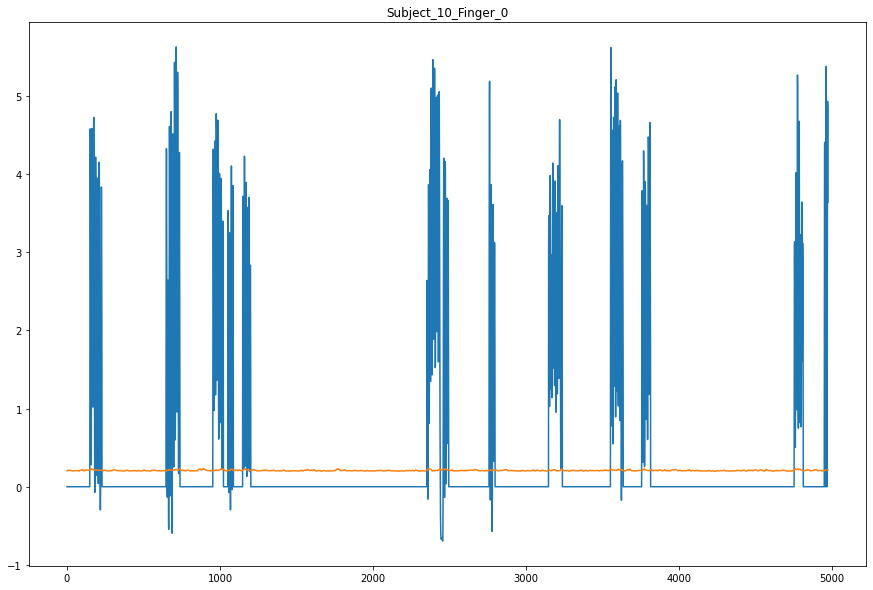

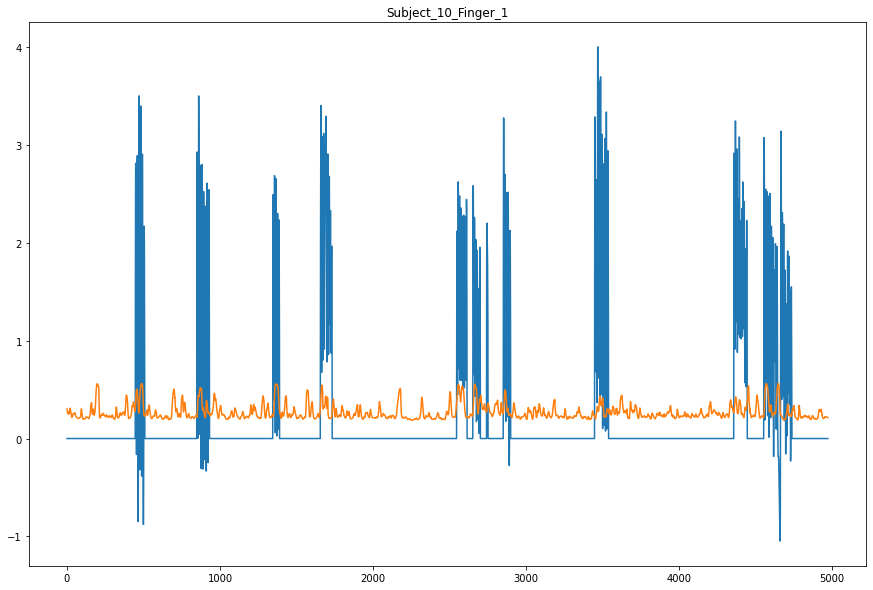

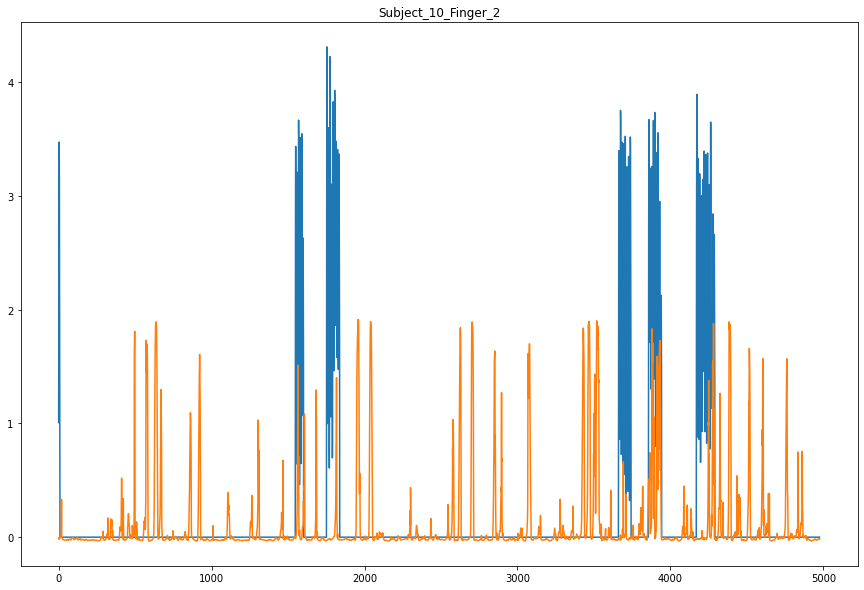

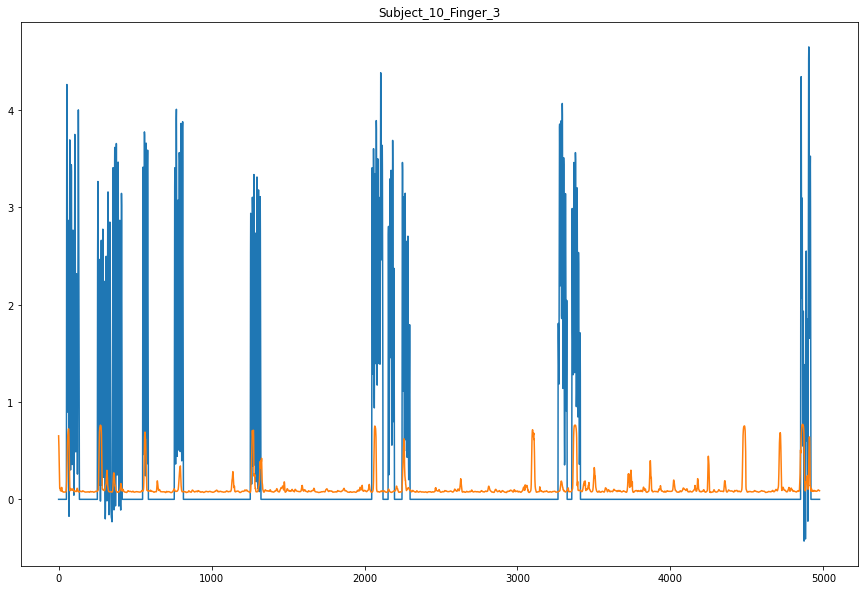

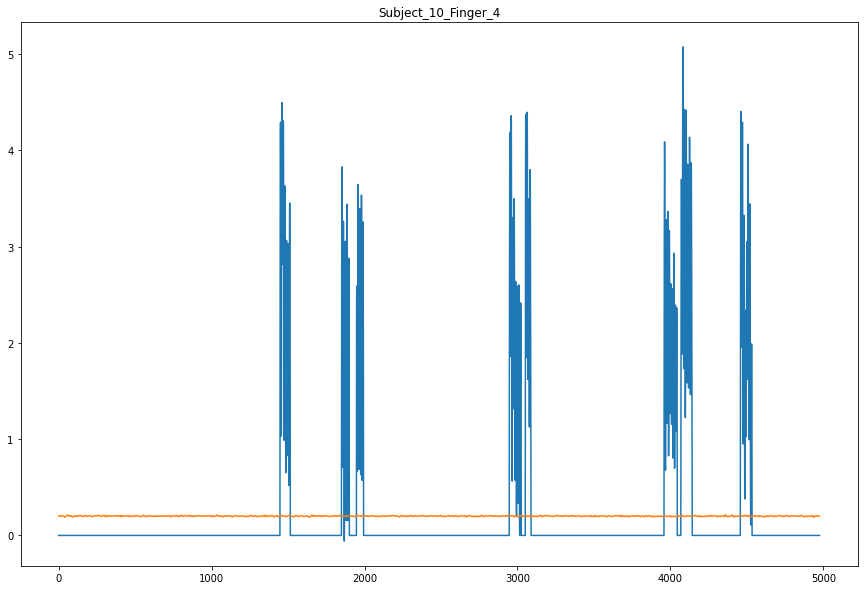

In [3]:
for Idx_subject in list([10,11,12]): # 3 subjects index 10-12
        bin = True
        all_corrcoeff = []
        for Finger in list([0,1,2,3,4]): # 5 fingers for each subject. 0:thumb, 1:index, 2:middle ...
            
            #load training data (TrainX: feature vectors, TrainY: labels)
            matData = sio.loadmat(data_path + '/BCImoreData_Subj_'+str(Idx_subject)+'_200msLMP.mat')
            TrainX = matData['Data_Feature'].transpose()
            TrainY = matData['SmoothedFinger']
            TrainY = TrainY [:,Finger]
            TrainY = TrainY.reshape(TrainY.shape[0],1)
            #load testing data (TestX: feature vectors, TestY: labels)
            matData = sio.loadmat(data_path + '/BCImoreData_Subj_'+str(Idx_subject)+'_200msLMPTest.mat')
            TestX = matData['Data_Feature'].transpose()
            TestY = matData['SmoothedFinger']
            TestY = TestY[:,Finger]
            TestY = TestY.reshape(TestY.shape[0],1)
            n_epochs =  50
            #paths to save the model and predictions
            PATH_corrcoef = 'Sbj' + str(Idx_subject) + 'f'+str(Finger)+'_corr_coefs'+str(bin) + '_E'+str(n_epochs)
            PATH_pre_trained = 'Sbj' + str(Idx_subject) + 'f'+str(Finger)+'_trained_model_fixed_pt_quantization'+str(bin)
            PATH_predictions = 'Sbj' + str(Idx_subject) + 'f'+str(Finger)+'_predictions_fixed_pt_quantization'+str(bin) + '_E'+str(n_epochs)

            # preprocessing 
            TrainX = remove_outliers(TrainX)
            
            x_scaler, y_scaler, TrainX, TestX, TrainY, TestY  = preprocessing(TrainX,TestX,TrainY,TestY)
            
            
            # from here, we reconstruct the input by "looking back" a few steps
            bins_before= 20 #How many bins of neural data prior to the output are used for decoding
            bins_current=1 #Whether to use concurrent time bin of neural data
            bins_after=0 #How many bins of neural data after the output are used for decoding
            
            TrainX=get_spikes_with_history(TrainX,bins_before,bins_after,bins_current)
            TrainX, TrainY = TrainX[bins_before:,:,:], TrainY[bins_before:,]
         
            TestX=get_spikes_with_history(TestX,bins_before,bins_after,bins_current)
            TestX, TestY = TestX[bins_before:,:,:], TestY[bins_before:,]
            
            # Now, we reconstructed TrainX/TestX to have a shape (num_of_samples, sequence_length, input_size)
            # We can fit this to the LSTM
            
            print("Run for finger "+str(Finger))

            n_hidden = 20
            n_layers = 5
            
            input_dim = TrainX.shape[2]
            output_dim = TrainY.shape[1]
            seq_len =  TrainX.shape[1]

            net = LSTM(input_dim, output_dim, seq_len,  n_hidden, n_layers, fixed_pt_quantize = bin)

            lossfunc = nn.MSELoss()

            optimizer = torch.optim.Adamax(net.parameters(), lr=0.003)
            net.train()


            ##training the initial model
            if False:
                net = torch.load(PATH_pre_trained)

            else:

                try:
                    corr_train, corr_val, corr_test = train(TrainX, TrainY,TestX,TestY, net, lossfunc, optimizer, num_epoch = n_epochs, clip = 5, Finger=Finger)
                except KeyboardInterrupt:
                    #save the model
                    print("saving...")
                #torch.save(net, PATH_pre_trained)
                #with open(os.path.join(result_path, PATH_pre_trained), 'wb') as f: #uncomment to save the model to drive
                #  pickle.dump(net, f) 
                print("model saved")

            ##test initial model
            net.eval()
            pred,h = net(torch.from_numpy(TestX).float(), net.init_hidden(TestX.shape[0]))
            pred = pred.detach().numpy()[-1,:,:]
            pred = y_scaler.inverse_transform(pred)
            TestY = y_scaler.inverse_transform(TestY)
            pred = pred.reshape((-1,))
            corrcoef = np.corrcoef(pred,TestY.reshape((-1,)))
            TestYShifted = TestY
            x = np.arange(TestYShifted.shape[0])
            #torch.save([corr_train, corr_val, corr_test], PATH_corrcoef)
            #with open(os.path.join(result_path, PATH_corrcoef), 'wb') as f:
            #  pickle.dump([corr_train, corr_val, corr_test], f) 
            #torch.save(pred, PATH_predictions)
            #with open(os.path.join(result_path, PATH_predictions), 'wb') as f:
            #  pickle.dump(pred, f) 
            fig_label = plt.figure(figsize=(15,10))
            plt.title("Subject_" + str(Idx_subject) + "_Finger_"+str(Finger))
            plt.plot(x, TestYShifted)
            plt.plot(x, pred)
            fig_label.savefig(figure_path + "/Subject_" + str(Idx_subject) + "_Finger_"+str(Finger))
            
            print ('Correlation coefficient test : {corrcoef}'.format(corrcoef=corrcoef[0,1]))   
            






# Analisys of the obtained data



[[1.         0.27037502]
 [0.27037502 1.        ]]


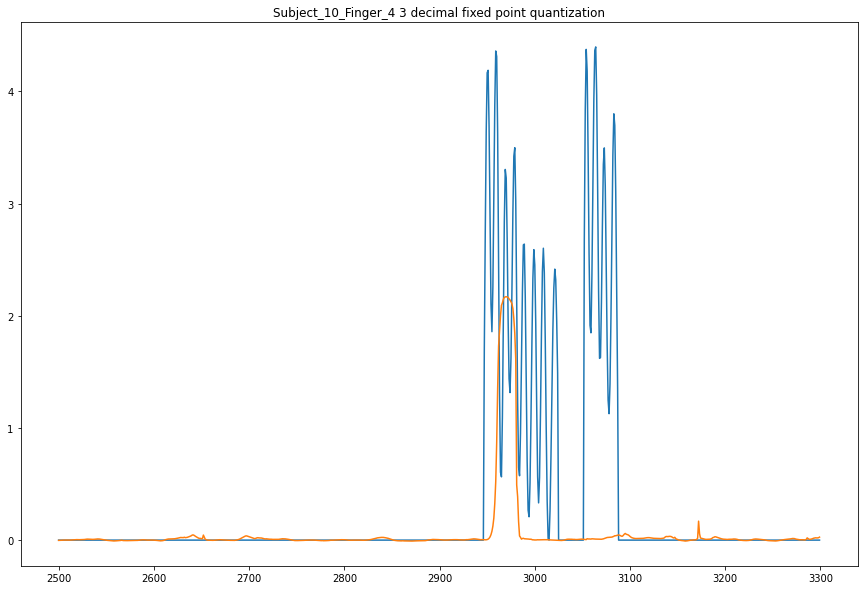

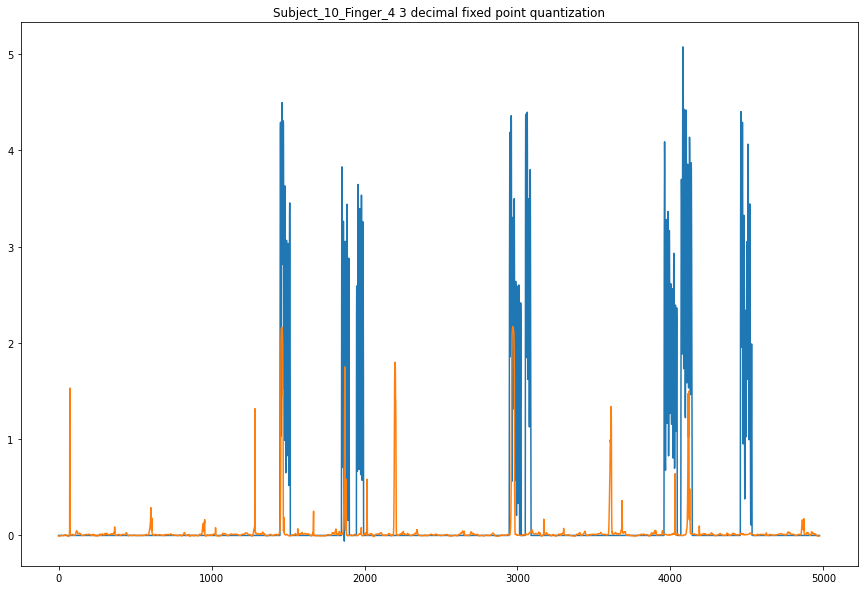

In [25]:
Idx_subject = 10
Finger = 4
path = 'Sbj'+ str(Idx_subject)+'f' + str(Finger) +'_trained_model_fixed_pt_quantizationTrue'

with open(os.path.join(result_path, path), 'rb') as f:
    net = pickle.load(f)

matData = sio.loadmat(data_path + '/BCImoreData_Subj_'+str(Idx_subject)+'_200msLMP.mat')
TrainX = matData['Data_Feature'].transpose()
TrainY = matData['SmoothedFinger']
TrainY = TrainY [:,Finger]
TrainY = TrainY.reshape(TrainY.shape[0],1)
#load testing data (TestX: feature vectors, TestY: labels)
matData = sio.loadmat(data_path + '/BCImoreData_Subj_'+str(Idx_subject)+'_200msLMPTest.mat')
TestX = matData['Data_Feature'].transpose()
TestY = matData['SmoothedFinger']
TestY = TestY[:,Finger]
TestY = TestY.reshape(TestY.shape[0],1)
TrainX = remove_outliers(TrainX)
            
x_scaler, y_scaler, TrainX, TestX, TrainY, TestY  = preprocessing(TrainX,TestX,TrainY,TestY)
bins_before= 20 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=0 #How many bins of neural data after the output are used for decoding
            
         
TestX=get_spikes_with_history(TestX,bins_before,bins_after,bins_current)
TestX, TestY = TestX[bins_before:,:,:], TestY[bins_before:,]
            
pred,h = net(torch.from_numpy(TestX).float(), net.init_hidden(TestX.shape[0]))
pred = pred.detach().numpy()[-1,:,:]
pred = y_scaler.inverse_transform(pred)
TestY = y_scaler.inverse_transform(TestY)
pred = pred.reshape((-1,))
corrcoef = np.corrcoef(pred,TestY.reshape((-1,)))
print(corrcoef)
TestYShifted = TestY
x = np.arange(TestYShifted.shape[0])
fig_label = plt.figure(figsize=(15,10))
plt.title("Subject_" + str(Idx_subject) + "_Finger_"+str(Finger)+' 3 decimal fixed point quantization')
plt.plot(x[2500:3300], TestYShifted[2500:3300])
plt.plot(x[2500:3300], pred[2500:3300])
fig_label.savefig(figure_path + "/Subject_" + str(Idx_subject) + "_Finger_"+str(Finger)+'3 decimal fixed point quantization')

fig_label = plt.figure(figsize=(15,10))
plt.title("Subject_" + str(Idx_subject) + "_Finger_"+str(Finger)+' 3 decimal fixed point quantization')
plt.plot(x, TestYShifted)
plt.plot(x, pred)
fig_label.savefig(figure_path + "/Subject_" + str(Idx_subject) + "_Finger_"+str(Finger)+' 3 decimal fixed point quantization')


In [7]:
path = 'Sbj10f1_trained_model_fixed_pt_quantizationTrue'
with open(os.path.join(result_path, path), 'rb') as f:
    net = pickle.load(f)
net.lstm.state_dict() # all the lstm weights are rounded to 3 decimals

OrderedDict([('weight_ih_l0',
              tensor([[-0.1460,  0.0500, -0.1030,  ..., -0.0250,  0.2260,  0.2650],
                      [-0.2100,  0.1530, -0.0930,  ..., -0.2380, -0.2480, -0.0410],
                      [ 0.1990,  0.0090, -0.2400,  ...,  0.1300,  0.2070, -0.1960],
                      ...,
                      [ 0.2880, -0.1150, -0.0320,  ..., -0.0850, -0.1310,  0.0900],
                      [ 0.0770, -0.0320, -0.2230,  ...,  0.0960, -0.2040,  0.1050],
                      [ 0.3190,  0.1980,  0.1020,  ...,  0.0600, -0.2760,  0.0780]])),
             ('weight_hh_l0',
              tensor([[-0.0300,  0.0640, -0.1460,  ...,  0.1500,  0.0290, -0.2740],
                      [ 0.2250, -0.0380, -0.0240,  ..., -0.0800, -0.1110, -0.0780],
                      [ 0.1780, -0.2260,  0.1070,  ..., -0.1370, -0.0870, -0.1290],
                      ...,
                      [ 0.1760, -0.1690, -0.1350,  ..., -0.2040, -0.0490, -0.1200],
                      [-0.2070,  0.1480, -0

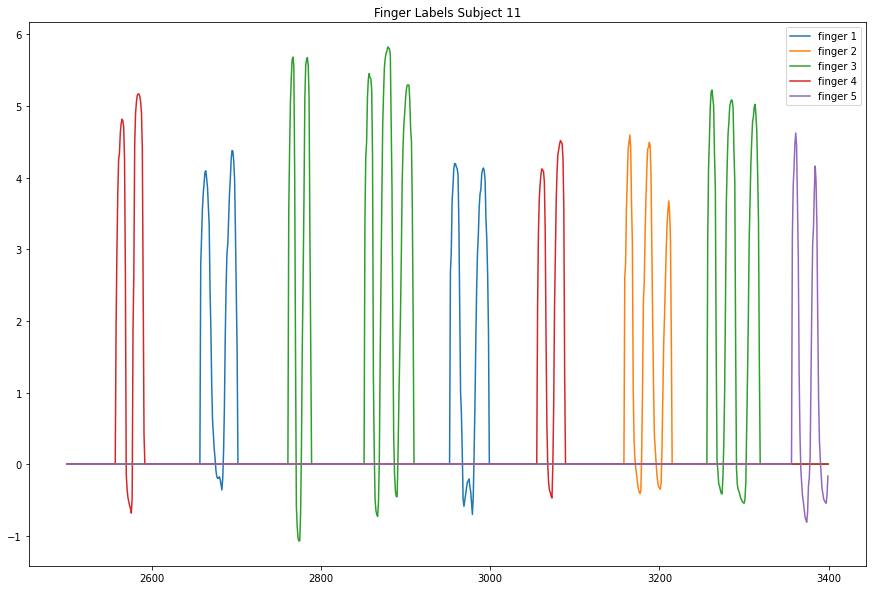

In [7]:
matData = sio.loadmat(main_path + '/BCImoreData_Subj_11_200msLMP.mat')
TrainY = matData['SmoothedFinger']
TrainYShifted = TrainY[20:,]
x = np.arange(TrainY.shape[0])
labels = plt.figure(figsize=(15,10))
plt.title('Finger Labels Subject 11')
plt.plot(x[2500:3400], TrainYShifted[2500:3400,0])
plt.plot(x[2500:3400], TrainYShifted[2500:3400,1])
plt.plot(x[2500:3400], TrainYShifted[2500:3400,2])
plt.plot(x[2500:3400], TrainYShifted[2500:3400,3])
plt.plot(x[2500:3400], TrainYShifted[2500:3400,4])
plt.legend(["finger 1", "finger 2", "finger 3","finger 4","finger 5"])

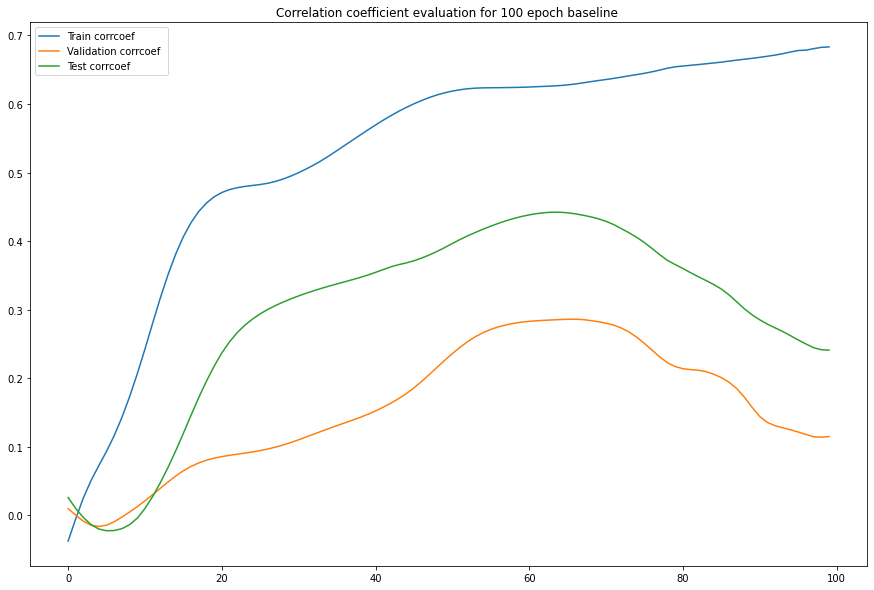

In [9]:

path = 'Sbj10f0_corr_coefsFalse_E100' 
with open(os.path.join(result_path, path), 'rb') as f:
    all_corrcoef =  pickle.load(f)
#print(np.max(all_corrcoef_test[0]))
fig_corrcoef = plt.figure(figsize=(15,10))
plt.plot( all_corrcoef[0])
plt.plot( all_corrcoef[1])
plt.plot( all_corrcoef[2])
plt.title('Correlation coefficient evaluation for 100 epoch baseline Sigmoid activation ')


plt.legend(["Train corrcoef ", "Validation corrcoef ", "Test corrcoef"], loc = 'best')
fig_corrcoef.savefig(os.path.join(figure_path, 'Corrcoef '+str(len(all_corrcoef[0]))+' epochs without binarization subj 10 finger 0.png'), format='png')

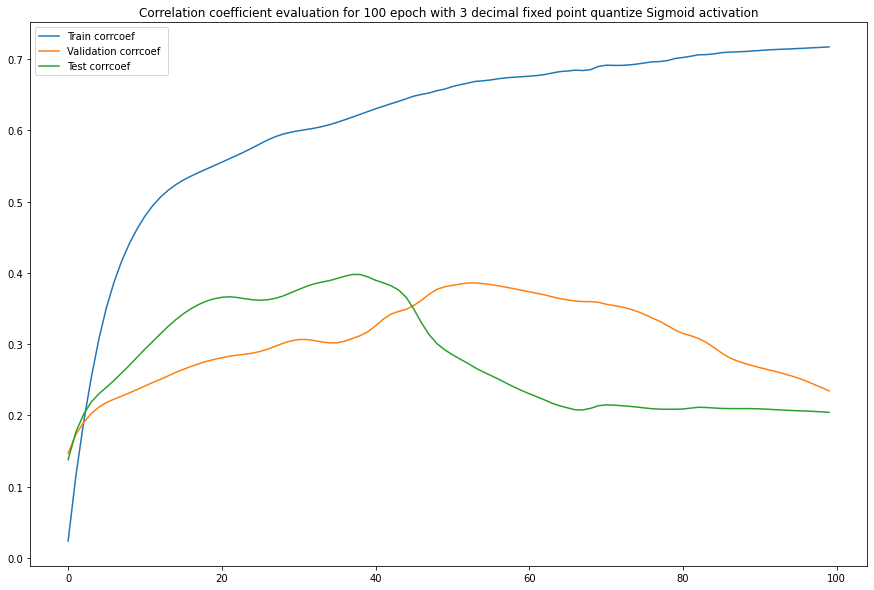

In [11]:

path= 'Sbj10f0_corr_coefsTrue_E100'
with open(os.path.join(result_path, path), 'rb') as f:
    all_corrcoef =  pickle.load(f)
fig_corrcoef = plt.figure(figsize=(15,10))
plt.plot( all_corrcoef[0])
plt.plot( all_corrcoef[1])
plt.plot( all_corrcoef[2])
plt.title('Correlation coefficient evaluation for 100 epoch with 3 decimal fixed point quantize Sigmoid activation')


plt.legend(["Train corrcoef ", "Validation corrcoef ", "Test corrcoef"], loc = 'best')
fig_corrcoef.savefig(os.path.join(figure_path, 'Corrcoef '+str(len(all_corrcoef[0]))+' epochs with 3 decimal fixed point quantize Sigmoid activation subj 10 finger 0.png'), format='png')

0.3152019073517857


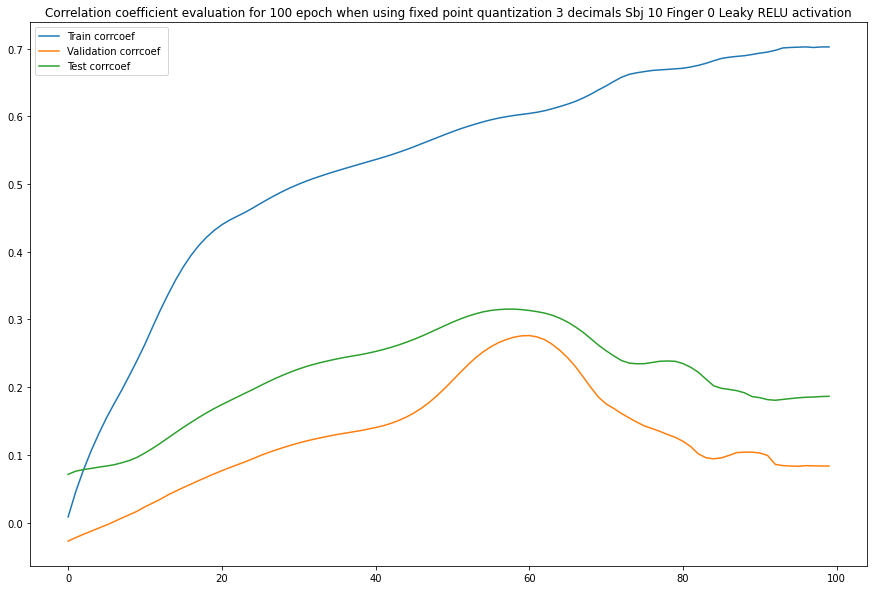

In [12]:
with open(os.path.join(result_path, '3dcorrcoefBin__test_100E_Sbj10'), 'rb') as f:
    all_corrcoef_test = pickle.load(f)
with open(os.path.join(result_path, '3dcorrcoefBin_val_100E_Sbj10'), 'rb') as f:
    all_corrcoef_val = pickle.load(f)
with open(os.path.join(result_path, '3dcorrcoefBin_100E_Sbj10'), 'rb') as f:
    all_corrcoef = pickle.load(f)
print(np.max(all_corrcoef_test[0]))
fig_corrcoef = plt.figure(figsize=(15,10))
plt.plot( all_corrcoef[0])
plt.plot( all_corrcoef_val[0])
plt.plot( all_corrcoef_test[0])
plt.title('Correlation coefficient evaluation for 100 epoch when using fixed point quantization 3 decimals Sbj 10 Finger 0 Leaky RELU activation')
plt.legend(["Train corrcoef ", "Validation corrcoef ", "Test corrcoef"], loc = 'best')
fig_corrcoef.savefig(os.path.join(figure_path, 'Corrcoef '+str(len(all_corrcoef_test))+' epochs with 3 dec relu subj 10 finger 0.png'), format='png')

0.080642761005812


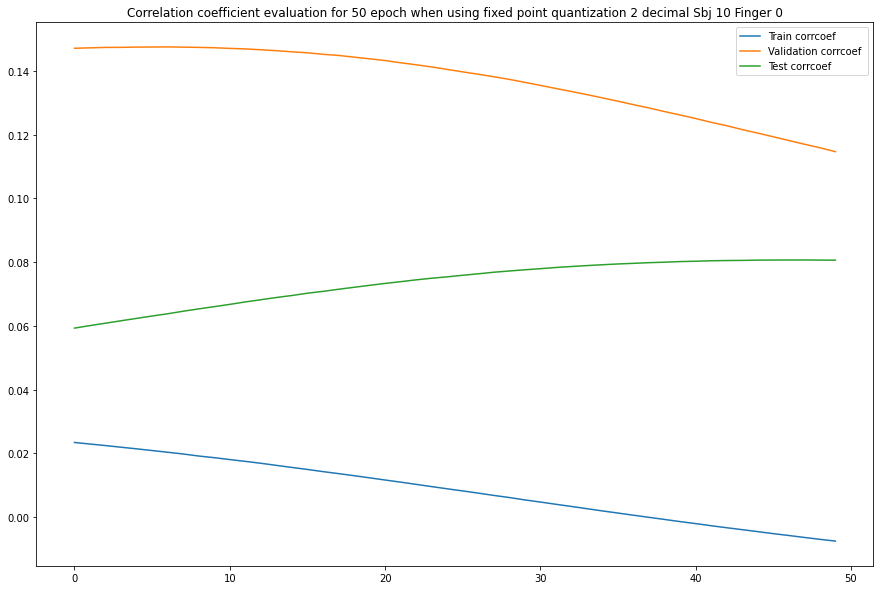

In [34]:
with open(os.path.join(result_path, '2dcorrcoefBin__test_50E_Sbj10'), 'rb') as f:
    all_corrcoef_test = pickle.load(f)
with open(os.path.join(result_path, '2dcorrcoefBin_val_50E_Sbj10'), 'rb') as f:
    all_corrcoef_val = pickle.load(f)
with open(os.path.join(result_path, '2dcorrcoefBin_50E_Sbj10'), 'rb') as f:
    all_corrcoef = pickle.load(f)
print(np.max(all_corrcoef_test[0]))
fig_corrcoef = plt.figure(figsize=(15,10))
plt.plot( all_corrcoef[0])
plt.plot( all_corrcoef_val[0])
plt.plot( all_corrcoef_test[0])
plt.title('Correlation coefficient evaluation for 50 epoch when using fixed point quantization 2 decimal Sbj 10 Finger 0')
plt.legend(["Train corrcoef ", "Validation corrcoef ", "Test corrcoef"], loc = 'best')
fig_corrcoef.savefig(os.path.join(figure_path, 'Corrcoef '+str(len(all_corrcoef_test))+' epochs fixed point quantization 2 decimal subj 10 finger 0.png'), format='png')

0.03882837958530719


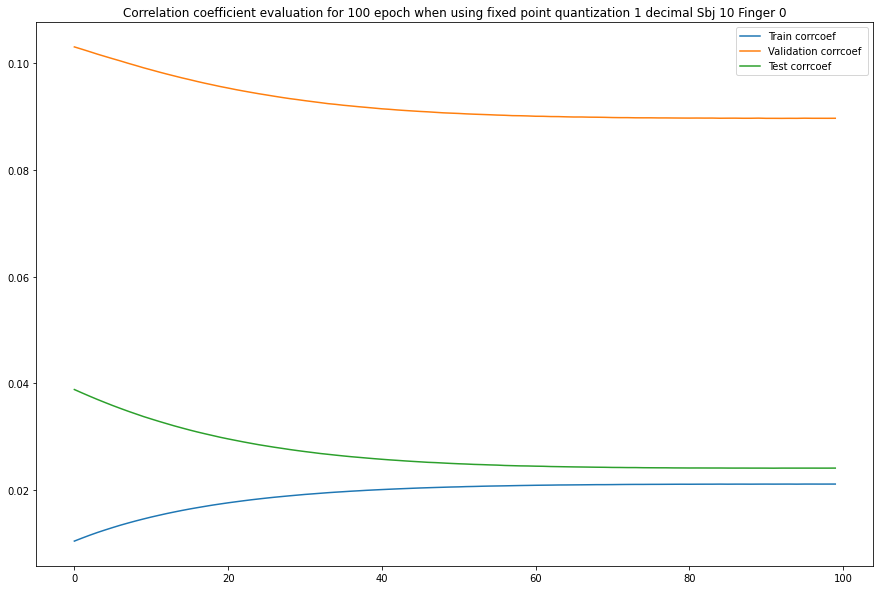

In [35]:
with open(os.path.join(result_path, 'corrcoefBin__test_100E_Sbj10'), 'rb') as f:
    all_corrcoef_test = pickle.load(f)
with open(os.path.join(result_path, 'corrcoefBin_val_100E_Sbj10'), 'rb') as f:
    all_corrcoef_val = pickle.load(f)
with open(os.path.join(result_path, 'corrcoefBin_100E_Sbj10'), 'rb') as f:
    all_corrcoef = pickle.load(f)
print(np.max(all_corrcoef_test[0]))
fig_corrcoef = plt.figure(figsize=(15,10))
plt.plot( all_corrcoef[0])
plt.plot( all_corrcoef_val[0])
plt.plot( all_corrcoef_test[0])
plt.title('Correlation coefficient evaluation for 100 epoch when using fixed point quantization 1 decimal Sbj 10 Finger 0')
plt.legend(["Train corrcoef ", "Validation corrcoef ", "Test corrcoef"], loc = 'best')
fig_corrcoef.savefig(os.path.join(figure_path, 'Corrcoef '+str(len(all_corrcoef_test))+' epochs with binarization subj 10 finger 0.png'), format='png')

In [6]:
all_corrcoef_test = []
print("Max corr coeff after 50 epochs baseline with Sigmoid activation")

for i in range(5):
  path = 'Sbj10f'+str(i)+'_corr_coefsFalse_E50'
  with open(os.path.join(result_path, path), 'rb') as f:
    all_corrcoef_test += [pickle.load(f)[2]]
    print(np.max(all_corrcoef_test[i]))

 

Max corr coeff after 50 epochs baseline with Sigmoid activation
0.39132225555408273
0.2835817629896477
0.16553109115738274
0.2544181263256135
0.3228514829897544


In [3]:
all_corrcoef_test = []
print("Max corr coeff after 50 epochs 3 dec fixed point quantization Sigmoid activation")

for i in range(5):
  path = 'TSbj10f'+str(i)+'_corr_coefsTrue_E50'
  with open(os.path.join(result_path, path), 'rb') as f:
    all_corrcoef_test += [pickle.load(f)[2]]
    print(np.max(all_corrcoef_test[i]))

 

Max corr coeff after 50 epochs 3 dec fixed point quantization sigmoid activation
0.398782172422232
0.30807918620717056
0.15349076507360715
0.20154549409380318
0.28693242833046523


In [26]:
all_corrcoef_test = []
print("Max corr coeff after 50 epochs baseline reLU activation")

for i in range(5):
  path = 'reluSbj10f'+str(i)+'_corr_coefsFalse_E50'
  with open(os.path.join(result_path, path), 'rb') as f:
    all_corrcoef_test += [pickle.load(f)[2]]
    print(np.max(all_corrcoef_test[i]))

 

Max corr coeff after 50 epochs baseline reLU activation
0.354181149759292
0.22271204732219707
0.13525168433283866
0.2910875989534492
0.31978105878106183


In [27]:
with open(os.path.join(result_path, 'corrcoefBin__test_50E_Sbj10'), 'rb') as f:
    all_corrcoef_test = pickle.load(f)
with open(os.path.join(result_path, 'corrcoefBin_val_50E_Sbj10'), 'rb') as f:
    all_corrcoef_val = pickle.load(f)
with open(os.path.join(result_path, 'corrcoefBin_50E_Sbj10'), 'rb') as f:
    all_corrcoef = pickle.load(f)
print("Max corr coeff after 50 epochs with binarization")
print(np.max(all_corrcoef_test[0]))
print(np.max(all_corrcoef_test[1]))
print(np.max(all_corrcoef_test[2]))
print(np.max(all_corrcoef_test[3]))
print(np.max(all_corrcoef_test[4]))

Max corr coeff after 50 epochs with binarization
-0.000976912407573762
0.006995188039309508
0.0348889879395748
0.007956333210360114
0.019576173385898666


In [30]:
with open(os.path.join(result_path, '1dcorrcoefBin__test_50E_Sbj10'), 'rb') as f:
    all_corrcoef_test = pickle.load(f)
with open(os.path.join(result_path, '1dcorrcoefBin_val_50E_Sbj10'), 'rb') as f:
    all_corrcoef_val = pickle.load(f)
with open(os.path.join(result_path, '1dcorrcoefBin_50E_Sbj10'), 'rb') as f:
    all_corrcoef = pickle.load(f)
print("Max corr coeff after 50 epochs with 1 decimal fixed point quantization")
print(np.max(all_corrcoef_test[0]))
print(np.max(all_corrcoef_test[1]))
print(np.max(all_corrcoef_test[2]))
print(np.max(all_corrcoef_test[3]))
print(np.max(all_corrcoef_test[4]))

Max corr coeff after 50 epochs with 1 decimal fixed point quantization
-0.07692718808344307
0.007702942491691873
0.0019081198123890206
-0.03657071480123027
-0.017970814430740018


In [20]:
with open(os.path.join(result_path, '2dcorrcoefBin__test_50E_Sbj10'), 'rb') as f:
    all_corrcoef_test = pickle.load(f)
with open(os.path.join(result_path, '2dcorrcoefBin_val_50E_Sbj10'), 'rb') as f:
    all_corrcoef_val = pickle.load(f)
with open(os.path.join(result_path, '2dcorrcoefBin_50E_Sbj10'), 'rb') as f:
    all_corrcoef = pickle.load(f)
print("Max corr coeff after 50 epochs with 2 decimals fixed point quantization")
print(np.max(all_corrcoef_test[0]))
print(np.max(all_corrcoef_test[1]))
print(np.max(all_corrcoef_test[2]))
print(np.max(all_corrcoef_test[3]))
print(np.max(all_corrcoef_test[4]))

Max corr coeff after 50 epochs with 2 decimals fixed point quantization
0.05792334325857187
-0.013453933654357935
-0.0743411159361556
-0.029183822983182672
0.057283060118546246


Train set results

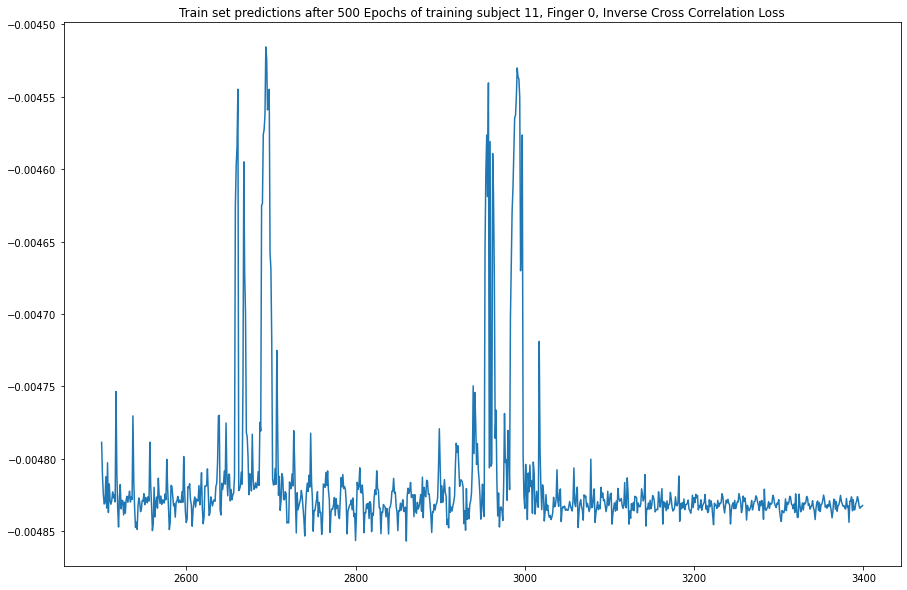

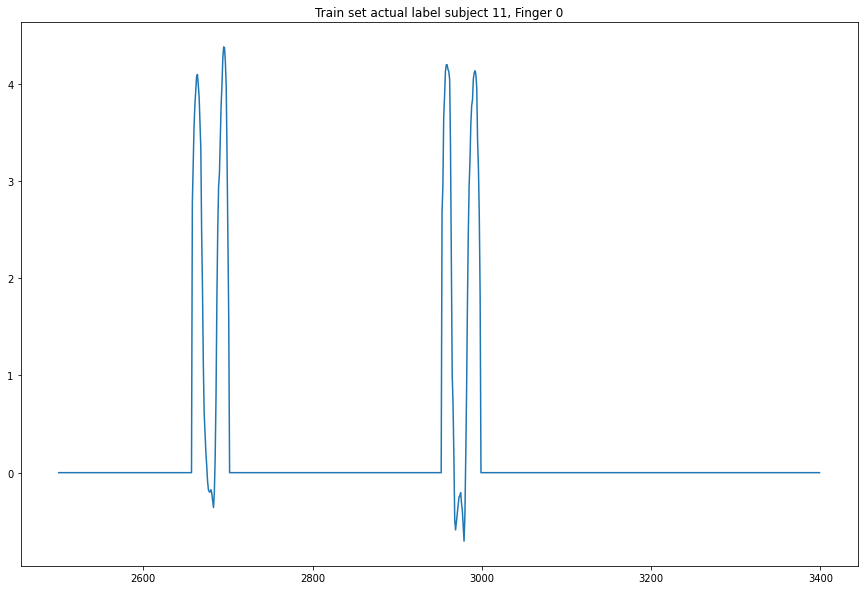

In [7]:
with open(os.path.join(result_path, 'predictionsNoBin_500E_Sbj11'), 'rb') as f:
    result = pickle.load(f)
matData = sio.loadmat(main_path + '/BCImoreData_Subj_11_200msLMP.mat')
TrainY = matData['SmoothedFinger']
TrainYShifted = TrainY[20:,]
x = np.arange(TrainYShifted.shape[0])
fig_pred = plt.figure(figsize=(15,10))
plt.title("Train set predictions after 500 Epochs of training subject 11, Finger 0, Inverse Cross Correlation Loss")
plt.plot(x[2500:3400], result[0][2500:3400])
fig_pred.show()
fig_label = plt.figure(figsize=(15,10))
plt.title("Train set actual label subject 11, Finger 0")

plt.plot(x[2500:3400], TrainYShifted[2500:3400, 0])

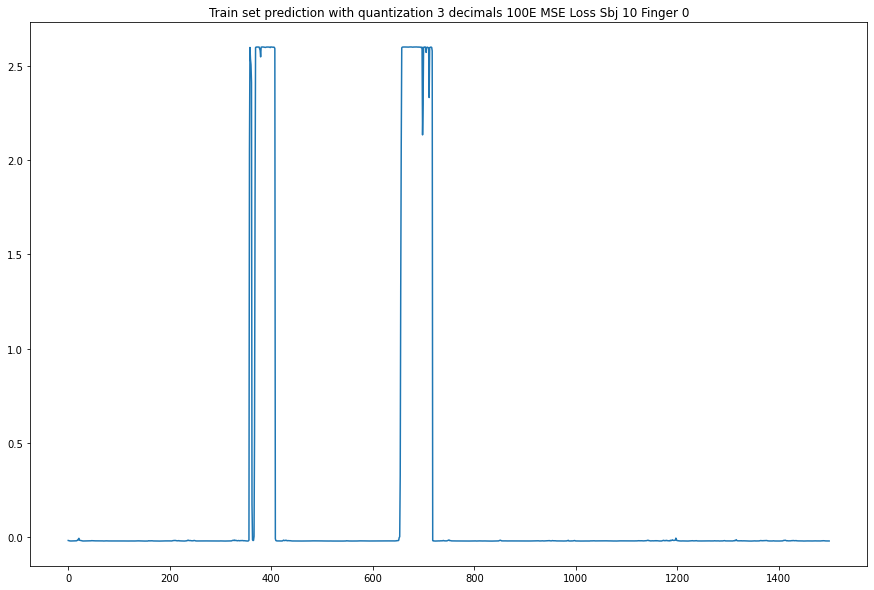

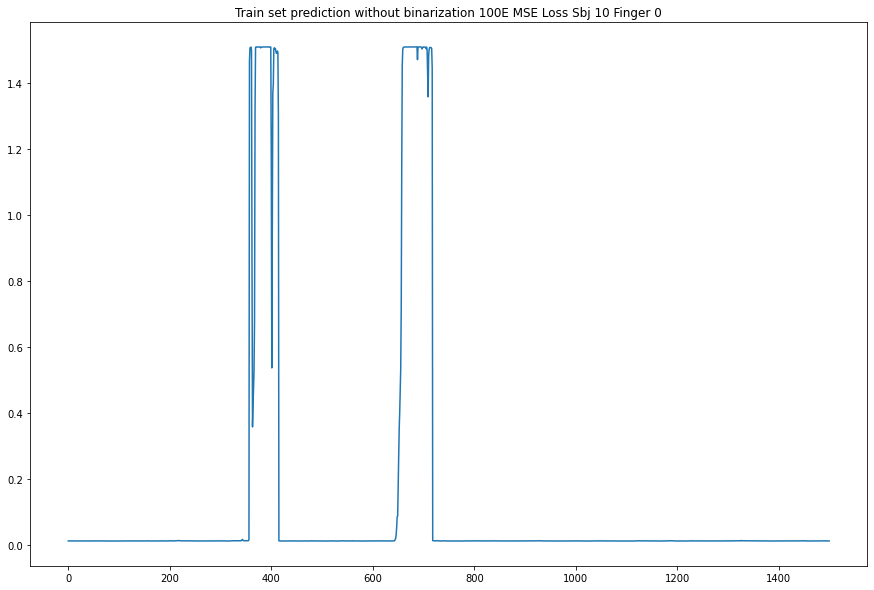

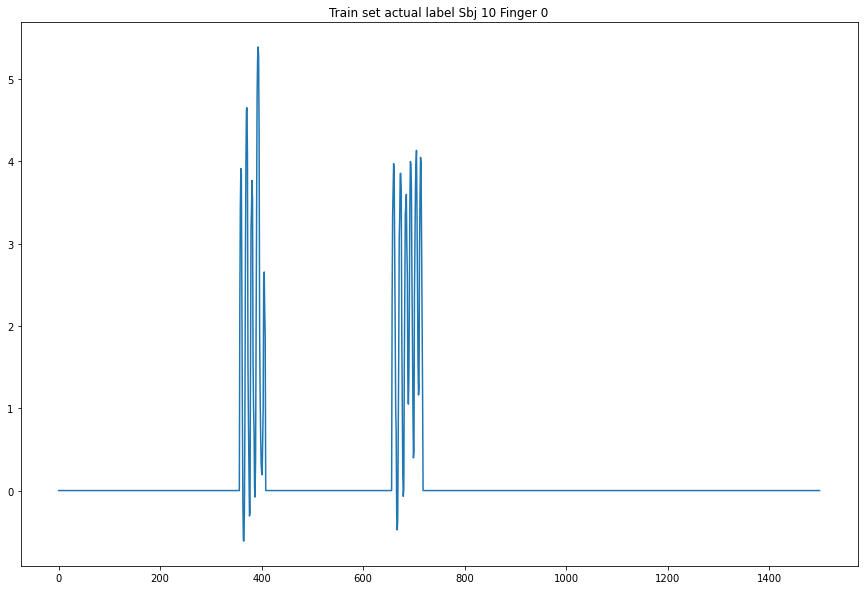

In [37]:


with open(os.path.join(result_path, 'predictionsBin_100E_Sbj10'), 'rb') as f: #result stored for finger 0
    resultBin100 = pickle.load(f)

with open(os.path.join(result_path, 'predictionsNoBin_100E_Sbj10'), 'rb') as f:
    resultNoBin100 = pickle.load(f)
matData = sio.loadmat(main_path + '/BCImoreData_Subj_10_200msLMP.mat')
TrainY = matData['SmoothedFinger']
TrainYShifted = TrainY[20:,]
x = np.arange(TrainYShifted.shape[0])
fig_bin = plt.figure(figsize=(15,10))
plt.title('Train set prediction with quantization 3 decimals 100E MSE Loss Sbj 10 Finger 0')
plt.plot(x[:1500], resultBin100[0][:1500])
fig_bin.show()
fig_pred = plt.figure(figsize=(15,10))
plt.title('Train set prediction without binarization 100E MSE Loss Sbj 10 Finger 0')
plt.plot(x[:1500], resultNoBin100[0][:1500])
fig_pred.show()
fig_label = plt.figure(figsize=(15,10))
plt.title('Train set actual label Sbj 10 Finger 0')
plt.plot(x[:1500], TrainYShifted[:1500,0])

Visualising the noise added when using the correlation coefficient as part of the loss function

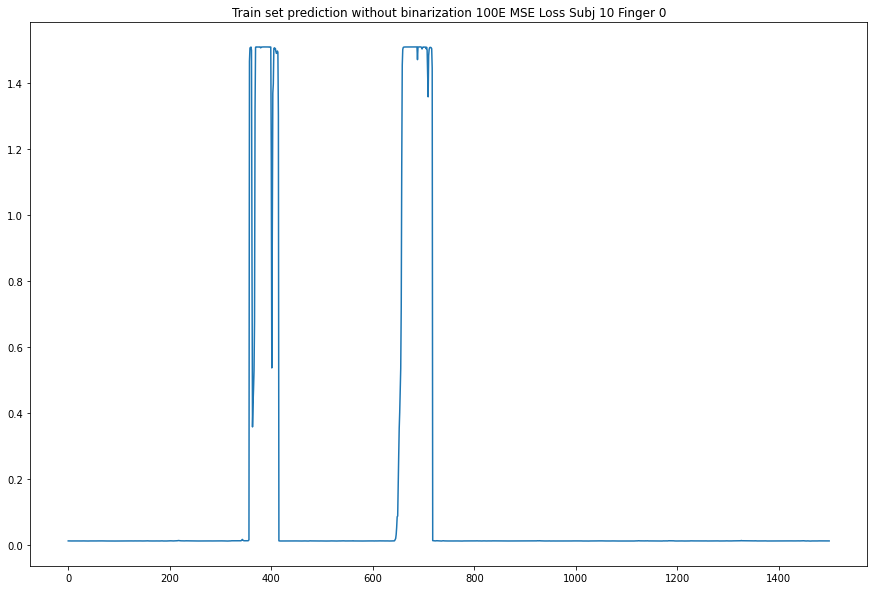

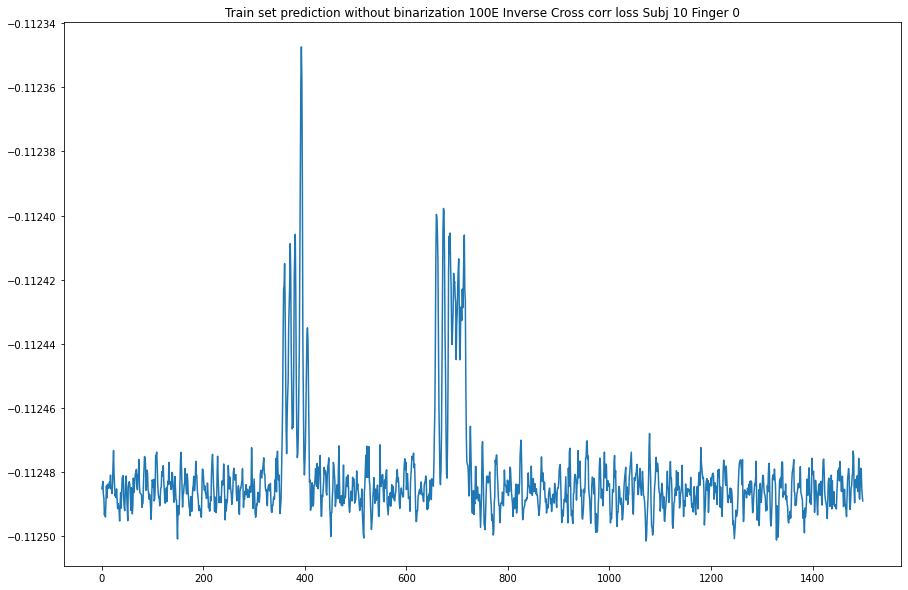

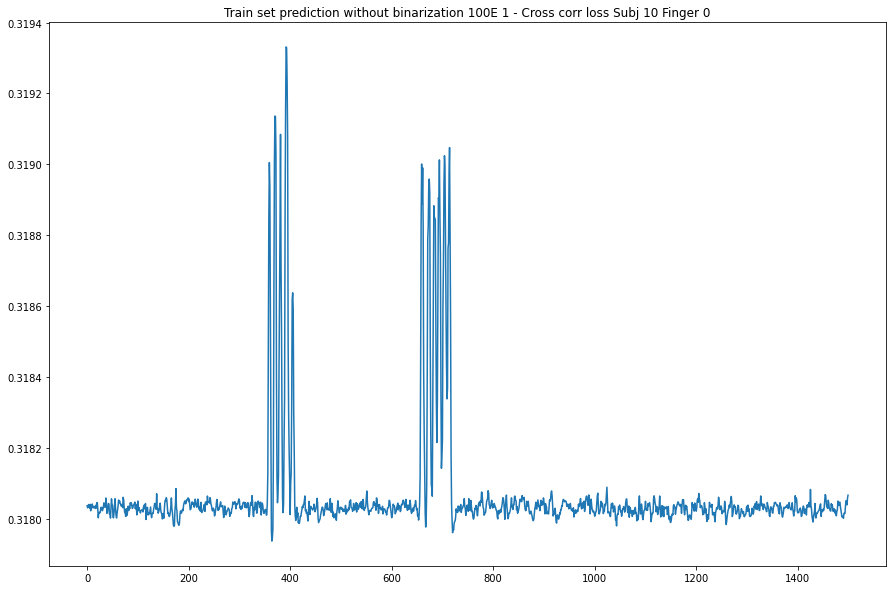

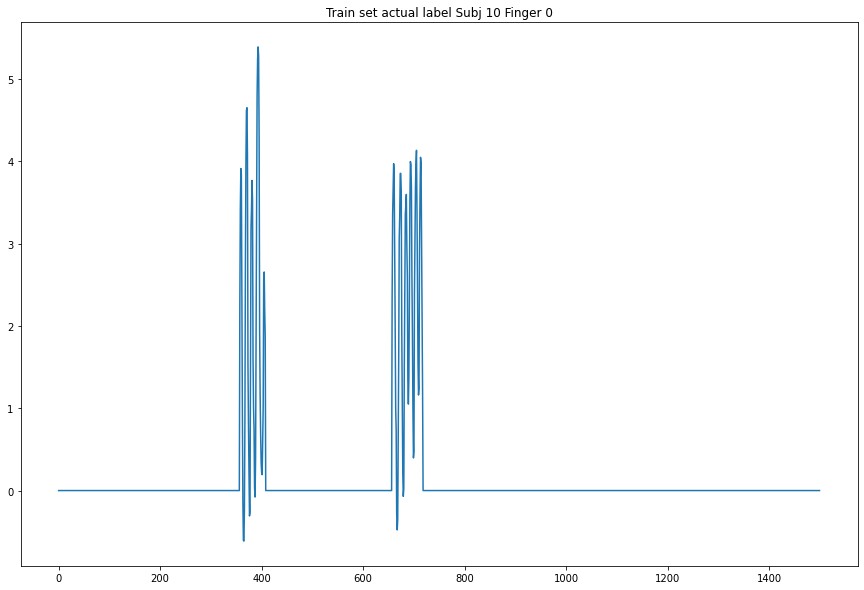

In [41]:
#### Train set prediction results using different loss functions after 100 epochs training
with open(os.path.join(result_path, 'predictionsNoBin_100E_Sbj10'), 'rb') as f:
    resultmse = pickle.load(f)
with open(os.path.join(result_path, 'CCLossPredNoBin_100E_Sbj10'), 'rb') as f:
    resultNoBin200 = pickle.load(f)
with open(os.path.join(result_path, '1-CCLossPredNoBin_100E_Sbj10'), 'rb') as f:
    result_minus_ccl = pickle.load(f)
matData = sio.loadmat(main_path + '/BCImoreData_Subj_10_200msLMP.mat')
TrainY = matData['SmoothedFinger']
TrainYShifted = TrainY[20:,]
x = np.arange(TrainYShifted.shape[0])
fig_bin = plt.figure(figsize=(15,10))
plt.title('Train set prediction without binarization 100E MSE Loss Subj 10 Finger 0')
plt.plot(x[:1500], resultmse[0][:1500])
fig_pred.show()
fig_pred = plt.figure(figsize=(15,10))
plt.title('Train set prediction without binarization 100E Inverse Cross corr loss Subj 10 Finger 0')
plt.plot(x[:1500], resultNoBin200[0][:1500])
fig_pred.show()
fig_pred = plt.figure(figsize=(15,10))
plt.title('Train set prediction without binarization 100E 1 - Cross corr loss Subj 10 Finger 0')
plt.plot(x[:1500], result_minus_ccl[0][:1500])
fig_pred.show()
fig_label = plt.figure(figsize=(15,10))
plt.title('Train set actual label Subj 10 Finger 0')
plt.plot(x[:1500], TrainYShifted[:1500,0])

Comparing the loss functions

Test set predictions

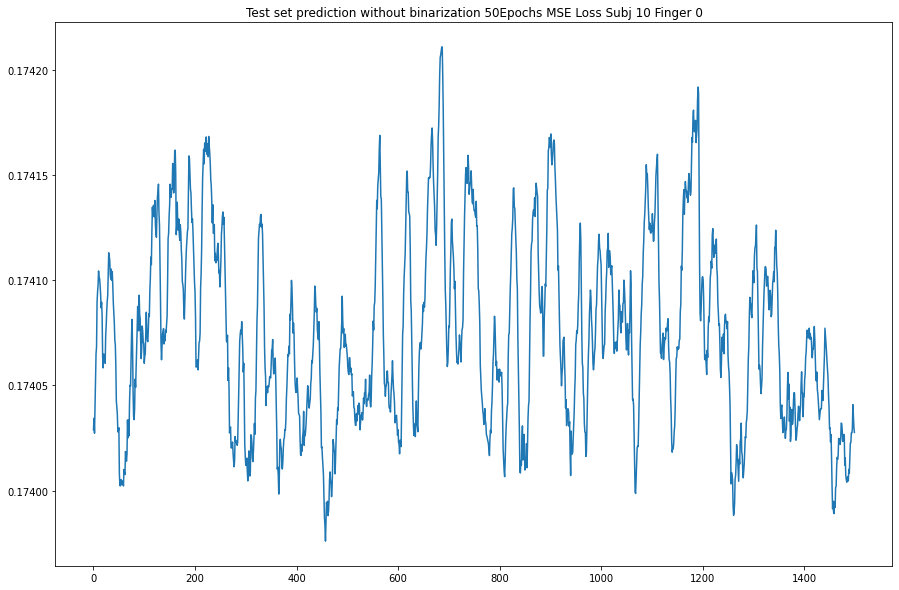

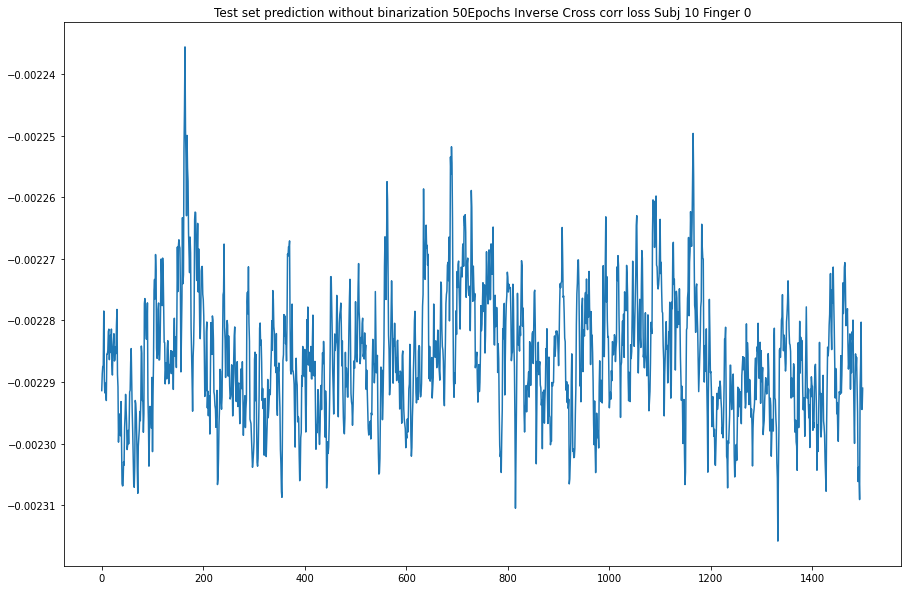

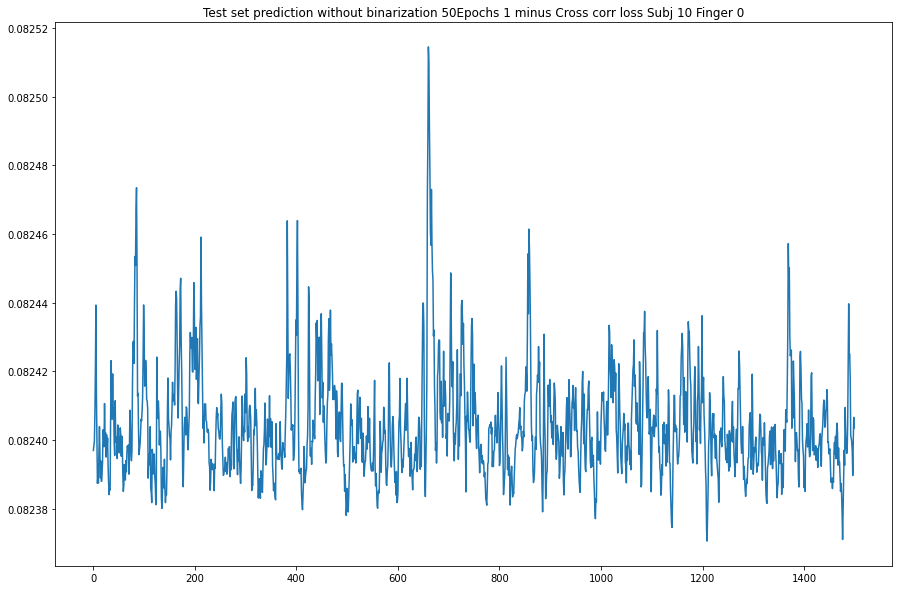

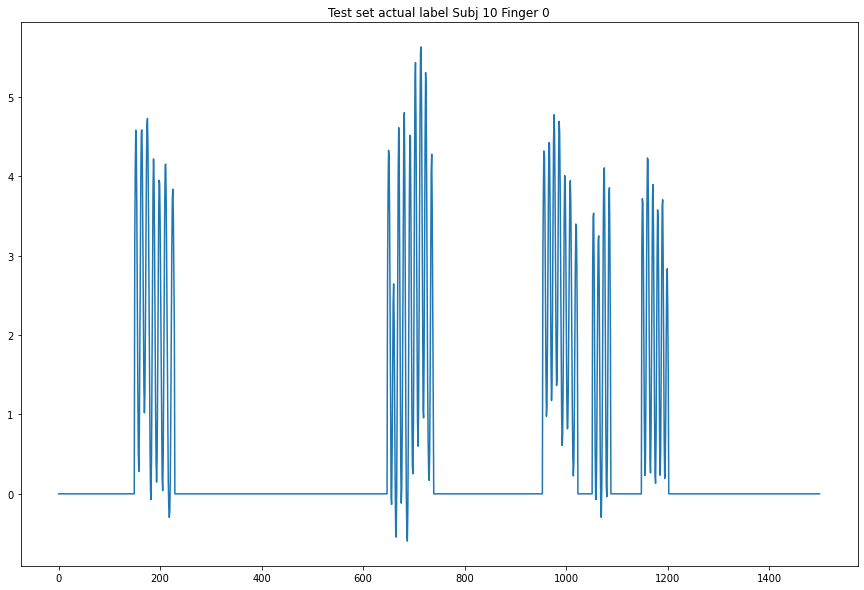

In [39]:
#### Test set prediction results using different loss functions 100 epochs
with open(os.path.join(result_path, 'testPredictionsNoBin_50E_Sbj10'), 'rb') as f:
    resultmse = pickle.load(f)

with open(os.path.join(result_path, 'CCLpredTestNoBin_50E_Sbj10'), 'rb') as f:
    result_ccl = pickle.load(f)
with open(os.path.join(result_path, '1-CCLpredTestNoBin_50E_Sbj10'), 'rb') as f:
    result_minus_ccl = pickle.load(f)
matData = sio.loadmat(main_path + '/BCImoreData_Subj_10_200msLMPTest.mat')
TestY = matData['SmoothedFinger']
TrainYShifted = TestY[20:,]
x = np.arange(TrainYShifted.shape[0])
fig_bin = plt.figure(figsize=(15,10))
plt.title('Test set prediction without binarization 50Epochs MSE Loss Subj 10 Finger 0')
plt.plot(x[:1500], resultmse[0][:1500])
fig_pred.show()
fig_pred = plt.figure(figsize=(15,10))
plt.title('Test set prediction without binarization 50Epochs Inverse Cross corr loss Subj 10 Finger 0')
plt.plot(x[:1500], result_ccl[0][:1500])
fig_pred.show()
fig_pred = plt.figure(figsize=(15,10))
plt.title('Test set prediction without binarization 50Epochs 1 minus Cross corr loss Subj 10 Finger 0')
plt.plot(x[:1500], result_minus_ccl[0][:1500])
fig_pred.show()
fig_label = plt.figure(figsize=(15,10))
plt.title('Test set actual label Subj 10 Finger 0')
plt.plot(x[:1500], TrainYShifted[:1500,0])

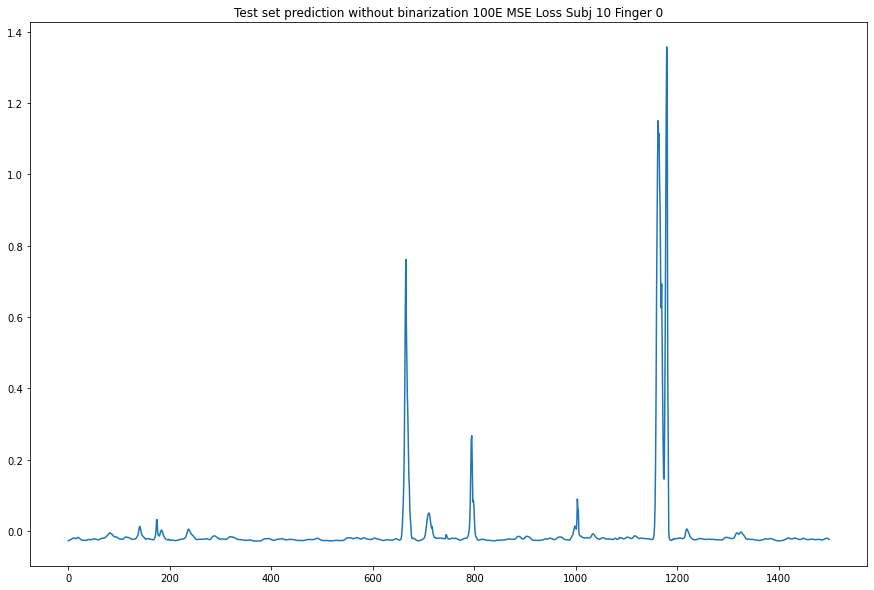

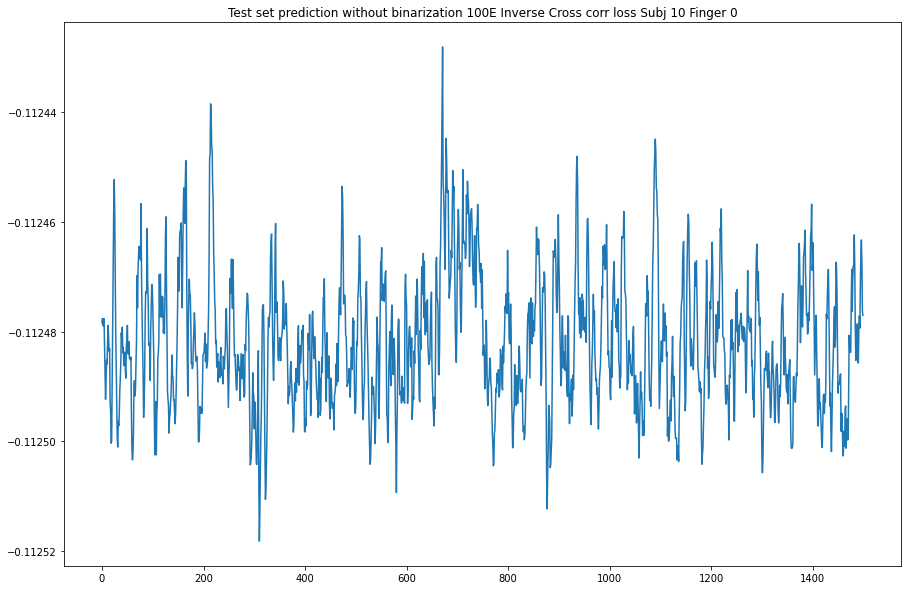

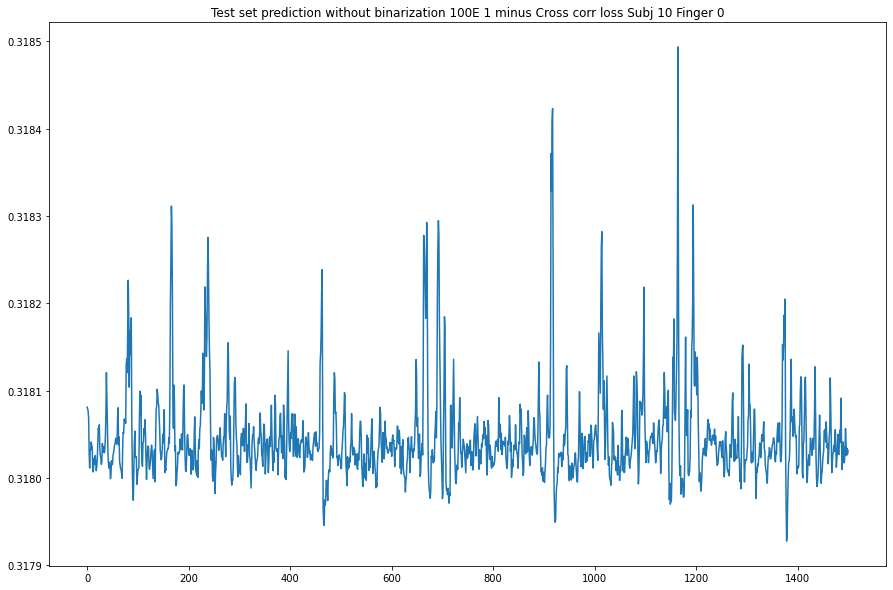

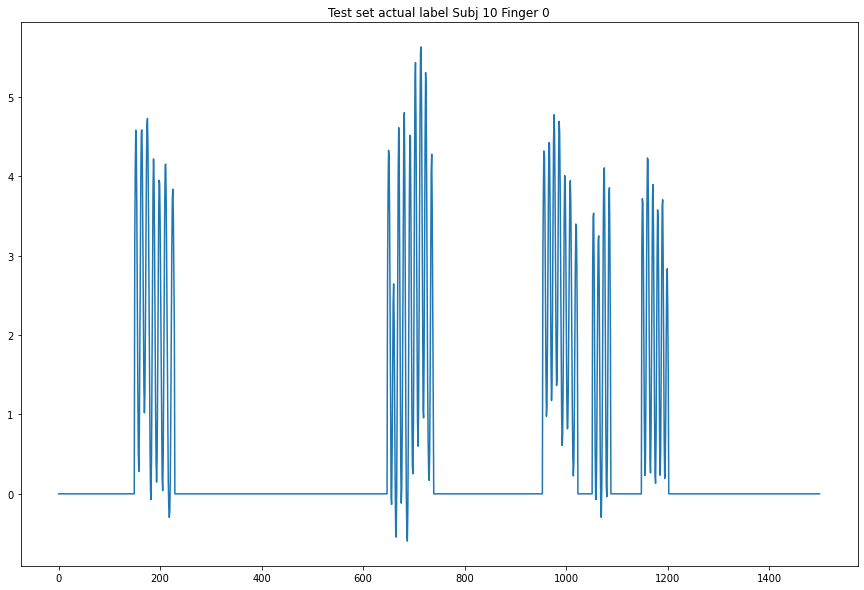

In [6]:
#### Test set prediction results using different loss functions 100 epochs
with open(os.path.join(result_path, 'Sbj10f0_predictions_fixed_pt_quantizationFalse_E100'), 'rb') as f:
    resultmse = pickle.load(f)

with open(os.path.join(result_path, 'CCLpredTestNoBin_100E_Sbj10'), 'rb') as f:
    result_ccl = pickle.load(f)
with open(os.path.join(result_path, '1-CCLpredTestNoBin_100E_Sbj10'), 'rb') as f:
    result_minus_ccl = pickle.load(f)
matData = sio.loadmat(main_path + '/BCImoreData_Subj_10_200msLMPTest.mat')
TestY = matData['SmoothedFinger']
TrainYShifted = TestY[20:,]
x = np.arange(TrainYShifted.shape[0])
fig_bin = plt.figure(figsize=(15,10))
plt.title('Test set prediction without binarization 100E MSE Loss Subj 10 Finger 0')
plt.plot(x[:1500], resultmse[:1500])
fig_bin.show()
fig_pred = plt.figure(figsize=(15,10))
plt.title('Test set prediction without binarization 100E Inverse Cross corr loss Subj 10 Finger 0')
plt.plot(x[:1500], result_ccl[0][:1500])
fig_pred.show()
fig_pred = plt.figure(figsize=(15,10))
plt.title('Test set prediction without binarization 100E 1 minus Cross corr loss Subj 10 Finger 0')
plt.plot(x[:1500], result_minus_ccl[0][:1500])
fig_pred.show()
fig_label = plt.figure(figsize=(15,10))
plt.title('Test set actual label Subj 10 Finger 0')
plt.plot(x[:1500], TrainYShifted[:1500,0])